In [1]:
import ase
from ase.build import bulk, surface, add_adsorbate
from ase.optimize import LBFGS, BFGS, FIRE
from ase.constraints import FixAtoms, Hookean
from ase.io import read, write, Trajectory

from orb_models.forcefield import pretrained
from orb_models.forcefield.calculator import ORBCalculator

from atom_editor import AtomEditorUI

device="cpu" # or device="cuda"
# or choose another model using ORB_PRETRAINED_MODELS[model_name]()
orbff = pretrained.orb_v3_conservative_inf_omat(
  device=device,
  precision="float32-high",   # or "float32-highest" / "float64
  compile=False
)
calc = ORBCalculator(orbff, device=device)

C:\Users\mmsoc\anaconda3\envs\ASE_BASE\Lib\site-packages\orb_models\utils.py:30: UserWarning: Setting global torch default dtype to torch.float32.
  warnings.warn(f"Setting global torch default dtype to {torch_dtype}.")


In [2]:
def makesurface(atoms,miller_indices=(1,1,1),layers=2,rep=[6,6,1], vac_height=50):
    atoms.positions += [0,0,0.1]
    s1 = surface(atoms, miller_indices,layers)
#     s1.center(vacuum=10.0, axis=2)
    s1.center(vacuum=vac_height/2, axis=2)          # 真空層= vacuum*2となります。
    s1 = s1.repeat(rep)
    s1.set_positions(s1.get_positions() - [0,0,min(s1.get_positions()[:,2])])
    s1.pbc = True
    return s1

In [ ]:
bulk = read("")
molecule = read("")
bulk.calc = calc
molecule.calc = calc

In [4]:
opt = LBFGS(bulk)
opt.run(fmax=0.02)

opt = LBFGS(molecule)
opt.run(fmax=0.02)

       Step     Time          Energy          fmax
LBFGS:    0 22:37:25      -57.336971        0.011680
       Step     Time          Energy          fmax
LBFGS:    0 22:37:25      -15.426880        1.331635
LBFGS:    1 22:37:26      -15.480590        0.544258
LBFGS:    2 22:37:26      -15.495739        0.328025
LBFGS:    3 22:37:26      -15.498796        0.129265
LBFGS:    4 22:37:26      -15.499019        0.023588
LBFGS:    5 22:37:26      -15.499027        0.002990


np.True_

In [5]:
slab = makesurface(bulk, (1,0,1), layers=4, rep=[3,4,1], vac_height=50)
ui = AtomEditorUI(slab)
ui.display()

In [6]:
mask = slab.positions[:, 2] > 10
del slab[mask]

In [7]:
slab.calc = calc
c = FixAtoms(indices=[atom.index for atom in slab if  atom.position[2] < 0.5])
slab.set_constraint(c)
opt = LBFGS(slab)
opt.run(fmax=0.05)

       Step     Time          Energy          fmax
LBFGS:    0 22:37:31    -2451.927979        1.499508
LBFGS:    1 22:37:38    -2453.444092        1.127698
LBFGS:    2 22:37:44    -2454.854492        0.750709
LBFGS:    3 22:37:50    -2455.463867        0.658521
LBFGS:    4 22:37:56    -2456.541260        0.506159
LBFGS:    5 22:38:02    -2456.988770        0.504669
LBFGS:    6 22:38:08    -2457.303711        0.448570
LBFGS:    7 22:38:15    -2457.538086        0.311043
LBFGS:    8 22:38:21    -2457.721191        0.255619
LBFGS:    9 22:38:27    -2457.849609        0.250122
LBFGS:   10 22:38:33    -2457.948242        0.207974
LBFGS:   11 22:38:39    -2458.017822        0.217848
LBFGS:   12 22:38:45    -2458.069336        0.205298
LBFGS:   13 22:38:51    -2458.114746        0.176439
LBFGS:   14 22:38:57    -2458.163086        0.139016
LBFGS:   15 22:39:03    -2458.216064        0.179517
LBFGS:   16 22:39:09    -2458.266113        0.151705
LBFGS:   17 22:39:15    -2458.306152        0.11

np.True_

In [8]:
ui = AtomEditorUI(slab)
ui.display()

In [9]:
import numpy as np
from ase import Atoms
from ase.geometry import get_distances

def add_random_molecules(
    slab: Atoms,
    molecule: Atoms,
    n: int = 5,
    min_height: float = 3.0,
    max_height: float = 8.0,
    min_dist: float = 2.0,
    max_trials: int = 1000,
    seed: int | None = None,
) -> Atoms:
    rng = np.random.default_rng(seed)

    atoms = slab.copy()
    cell = atoms.get_cell()
    pbc = atoms.get_pbc()

    # スラブ最上面の z
    top_z = slab.get_positions()[:, 2].max()

    # 分子重心を原点に
    mol0 = molecule.copy()
    mol0.positions -= mol0.get_center_of_mass()

    for i in range(n):
        placed = False

        for trial in range(max_trials):
            # XY: セル内ランダム
            fx, fy = rng.random(2)
            shift_xy = fx * cell[0] + fy * cell[1]

            # 高さ: [min_height, max_height]
            h = rng.uniform(min_height, max_height)
            z = top_z + h

            mol = mol0.copy()
            mol.positions += shift_xy + np.array([0.0, 0.0, z])

            # --- PBC + MIC を考慮した衝突判定 ---
            pos_exist = atoms.get_positions()
            pos_new = mol.get_positions()

            # ここで MIC 込みの距離行列が取れる
            _, d = get_distances(pos_new, pos_exist, cell=cell, pbc=pbc)

            dmin = d.min()

            if dmin >= min_dist:
                atoms += mol
                placed = True
                break

        if not placed:
            print(
                f"Warning: {i+1} 個目の分子を "
                f"{max_trials} 回試行しても衝突なしで置けませんでした。"
            )

    return atoms


In [10]:
import numpy as np
from ase import Atoms
from ase.geometry import get_distances

def random_rotation_matrix(rng: np.random.Generator) -> np.ndarray:
    """SO(3) 上で一様なランダム回転行列 (3x3) を返す。"""
    u1, u2, u3 = rng.random(3)
    q1 = np.sqrt(1 - u1) * np.sin(2 * np.pi * u2)
    q2 = np.sqrt(1 - u1) * np.cos(2 * np.pi * u2)
    q3 = np.sqrt(u1) * np.sin(2 * np.pi * u3)
    q4 = np.sqrt(u1) * np.cos(2 * np.pi * u3)  # (x,y,z,w) で w=q4

    x, y, z, w = q1, q2, q3, q4
    R = np.array([
        [1 - 2*(y*y + z*z),     2*(x*y - z*w),     2*(x*z + y*w)],
        [    2*(x*y + z*w), 1 - 2*(x*x + z*z),     2*(y*z - x*w)],
        [    2*(x*z - y*w),     2*(y*z + x*w), 1 - 2*(x*x + y*y)],
    ])
    return R

def add_random_molecules(
    slab: Atoms,
    molecule: Atoms,
    n: int = 5,
    min_height: float = 3.0,
    max_height: float = 8.0,
    min_dist: float = 2.0,
    max_trials: int = 1000,
    seed: int | None = None,
    random_rotate: bool = True,   # 追加
) -> Atoms:
    rng = np.random.default_rng(seed)

    atoms = slab.copy()
    cell = atoms.get_cell()
    pbc = atoms.get_pbc()

    top_z = slab.get_positions()[:, 2].max()

    # 分子重心を原点に
    mol0 = molecule.copy()
    mol0.positions -= mol0.get_center_of_mass()

    for i in range(n):
        placed = False

        for trial in range(max_trials):
            # XY: セル内ランダム
            fx, fy = rng.random(2)
            shift_xy = fx * cell[0] + fy * cell[1]

            # 高さ: [min_height, max_height]
            h = rng.uniform(min_height, max_height)
            z = top_z + h

            mol = mol0.copy()

            # --- ランダム回転を追加 ---
            if random_rotate:
                R = random_rotation_matrix(rng)
                mol.positions = mol.positions @ R.T  # (N,3) に右から回転

            # 平行移動
            mol.positions += shift_xy + np.array([0.0, 0.0, z])

            # --- PBC + MIC を考慮した衝突判定 ---
            pos_exist = atoms.get_positions()
            pos_new = mol.get_positions()

            _, d = get_distances(pos_new, pos_exist, cell=cell, pbc=pbc)
            dmin = d.min()

            if dmin >= min_dist:
                atoms += mol
                placed = True
                break

        if not placed:
            print(
                f"Warning: {i+1} 個目の分子を "
                f"{max_trials} 回試行しても衝突なしで置けませんでした。"
            )

    return atoms


In [11]:
atoms = slab.copy()
#add_adsorbate(atoms, molecule, 5.0)
#atoms.positions[-len(molecule):] += atoms.cell[0] * [0.5, 0, 0]
#atoms.positions[-len(molecule):] += atoms.cell[1] * [0, 0.5, 0]
atoms = add_random_molecules(atoms, molecule, n=80, min_height=10, max_height=30, min_dist=2.0, seed=123)
ui = AtomEditorUI(atoms)
ui.display()

In [12]:
"""
atoms:  すでに定義された ASE Atoms
        （固体＋真空層＋吸着分子、必要なら constraint も設定済み）
calc:   atoms にセットする calculator（EMT, ReaxFF(LAMMPS), DFT など）

この関数がやること:
  1. calculator をセット
  2. 初期速度を MB 分布で付与（並進・回転を除去）
  3. Langevin MD オブジェクトを作成
  4. traj/log を書き出しながら MD 実行
"""

import os
import numpy as np

from ase import units
from ase.io import Trajectory
from ase.md.langevin import Langevin
from ase.md.velocitydistribution import (
    MaxwellBoltzmannDistribution,
    Stationary,
    ZeroRotation,
)


def run_langevin_md(
    atoms,
    calc,
    temperature=500.0,          # ターゲット温度 [K]
    timestep_fs=1.0,            # タイムステップ [fs]
    friction=0.005,             # 摩擦係数 [1/fs]
    total_steps=20000,          # 総ステップ数
    initial_temperature=None,   # 初期速度用温度（Noneなら temperature と同じ）
    seed=42,                    # 乱数シード
    traj_filename="md.traj",    # 構造トラジェクトリ
    log_filename="md.log",      # エネルギーログ
    log_interval=50,            # ログの書き出し間隔（ステップ数）
    traj_interval=10,           # トラジェクトリ書き出し間隔（ステップ数）
    fix_center_of_mass=True,    # 系全体の並進運動を抑制
    verbose_interval=100,       # 標準出力での表示間隔（ステップ数）
):
    """
    既に用意された固体表面＋吸着分子系に対して、Langevin MD を実行する汎用関数。
    """

    # -------------------------
    # 0. 乱数シードの設定
    # -------------------------
    np.random.seed(seed)

    # -------------------------
    # 1. calculator をセット
    # -------------------------
    atoms.calc = calc

    # -------------------------
    # 2. 初期速度の付与
    # -------------------------
    if initial_temperature is None:
        initial_temperature = temperature

    # Maxwell-Boltzmann 分布に従う初期速度
    MaxwellBoltzmannDistribution(atoms, temperature_K=initial_temperature)

    # 系全体の並進運動を 0 にする（運動量を打ち消す）
    Stationary(atoms)

    # 全体回転を 0 にする（特に分子部分の挙動をきれいにしたい場合）
    ZeroRotation(atoms)

    # -------------------------
    # 3. Langevin MD オブジェクト
    # -------------------------
    timestep = timestep_fs * units.fs

    # 既存ログがあれば消しておく
    if log_filename and os.path.exists(log_filename):
        os.remove(log_filename)

    dyn = Langevin(
        atoms=atoms,
        timestep=timestep,
        temperature_K=temperature,
        friction=friction,
        fixcm=fix_center_of_mass,
        logfile=log_filename if log_filename else None,
        loginterval=log_interval,
    )

    # -------------------------
    # 4. トラジェクトリの設定
    # -------------------------
    traj = None
    if traj_filename:
        # "w"：新規作成（既存があれば上書き）
        traj = Trajectory(traj_filename, "w", atoms)

        # 指定ステップごとに構造を書き出し
        dyn.attach(traj.write, interval=traj_interval)

    # -------------------------
    # 5. ステータス表示関数
    # -------------------------
    def print_status():
        time_fs = dyn.get_time() / units.fs
        epot = atoms.get_potential_energy()
        ekin = atoms.get_kinetic_energy()
        etot = epot + ekin
        temp_inst = atoms.get_temperature()

        print(
            f"time = {time_fs:8.1f} fs | "
            f"T = {temp_inst:7.2f} K | "
            f"E_pot = {epot:8.4f} eV | "
            f"E_kin = {ekin:8.4f} eV | "
            f"E_tot = {etot:8.4f} eV"
        )

    if verbose_interval is not None and verbose_interval > 0:
        dyn.attach(print_status, interval=verbose_interval)

    # -------------------------
    # 6. MD 実行
    # -------------------------
    print(
        f"Starting Langevin MD: T={temperature} K, "
        f"dt={timestep_fs} fs, friction={friction}, steps={total_steps}"
    )

    dyn.run(total_steps)

    print("MD finished.")
    if traj_filename:
        print(f"Trajectory saved to: {traj_filename}")
    if log_filename:
        print(f"Log saved to:        {log_filename}")


In [13]:

# ---- 下側スラブを固定（既存のやつ） ----
z_fix_threshold = 0.5
bottom_mask = [pos[2] < z_fix_threshold for pos in atoms.positions]
fix_bottom = FixAtoms(mask=bottom_mask)

# ---- 壁の位置を決める ----
# スラブ最上面の z を基準に、例えば +7 Å のところに“天井”を置く
top_z = atoms.positions[:, 2].max()
z_wall = top_z + 2.0  # 好きな値で調整
k_wall = 0.5  # eV/Å^2 程度から試す

# 壁を効かせたい原子（例：固定されていない原子すべて）
mobile_indices = [i for i, pos in enumerate(atoms.positions)
                  if pos[2] >= z_fix_threshold]

constraints = [fix_bottom]

for i in mobile_indices:
    # z = z_wall の平面: 0*x + 0*y + 1*z - z_wall = 0 → (0, 0, 1, -z_wall)
    constraints.append(Hookean(a1=i, a2=(0.0, 0.0, 1.0, -z_wall), k=k_wall))

atoms.set_constraint(constraints)

# 上で定義した汎用関数で MD 実行
run_langevin_md(
    atoms,
    calc,
    temperature=500.0,       # 例えば 600 K
    timestep_fs=1.0,         # H を含むなら 0.5 fs 程度も一案
    friction=0.01,          # 少し強めの熱浴カップリング
    total_steps=100000,       # 25 ps の計算 (0.5 fs × 5e4)
    traj_filename="surf_ads_md.traj",
    log_filename="surf_ads_md.log",
)


Starting Langevin MD: T=500.0 K, dt=1.0 fs, friction=0.01, steps=100000
time =      0.0 fs | T =  493.94 K | E_pot = -3691.2124 eV | E_kin =  34.9882 eV | E_tot = -3656.2243 eV
time =    100.0 fs | T =  546.92 K | E_pot = -3694.5461 eV | E_kin =  38.7410 eV | E_tot = -3655.8051 eV
time =    200.0 fs | T =  535.43 K | E_pot = -3694.8423 eV | E_kin =  37.9271 eV | E_tot = -3656.9152 eV
time =    300.0 fs | T =  541.01 K | E_pot = -3695.6146 eV | E_kin =  38.3223 eV | E_tot = -3657.2923 eV
time =    400.0 fs | T =  491.97 K | E_pot = -3692.9317 eV | E_kin =  34.8483 eV | E_tot = -3658.0834 eV
time =    500.0 fs | T =  506.54 K | E_pot = -3693.9598 eV | E_kin =  35.8808 eV | E_tot = -3658.0790 eV
time =    600.0 fs | T =  513.16 K | E_pot = -3694.3765 eV | E_kin =  36.3494 eV | E_tot = -3658.0272 eV
time =    700.0 fs | T =  497.52 K | E_pot = -3692.9920 eV | E_kin =  35.2413 eV | E_tot = -3657.7507 eV
time =    800.0 fs | T =  502.53 K | E_pot = -3693.3640 eV | E_kin =  35.5962 eV | E_tot

KeyboardInterrupt: 

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from io import StringIO

plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams["font.size"] = 12


def load_md_log(log_filename="md.log"):
    """
    MD ログファイルから数値行だけを抜き出して読み込む。
    行頭が数字 / + / - / . で始まる行だけをデータとみなす。
    """
    lines_numeric = []
    with open(log_filename, "r") as f:
        for line in f:
            s = line.strip()
            if not s:
                continue  # 空行はスキップ
            c = s[0]
            if c in "0123456789-+.":
                lines_numeric.append(line)
            # それ以外（Time[ps] とか Step とか）は無視

    data_str = "".join(lines_numeric)
    data = np.loadtxt(StringIO(data_str))

    time = data[:, 0]
    etot = data[:, 1]
    epot = data[:, 2]
    ekin = data[:, 3]
    temp = data[:, 4]
    return time, etot, epot, ekin, temp


def plot_md_log(log_filename="md.log", savefig=None, fs_to_ps=True):
    """
    Langevin MD ログのプロットを表示する（Jupyter ノートブック用）。
    """
    time, etot, epot, ekin, temp = load_md_log(log_filename)

    # ログの時間が ps 表示なら fs_to_ps=False にしてください
    if fs_to_ps:
        time = time * 1e-3  # fs → ps 変換（もともと ps ならこの行は消す）

    fig, axes = plt.subplots(4, 1, figsize=(10, 12), sharex=True)

    axes[0].plot(time, etot, lw=1.2)
    axes[0].set_ylabel("E_tot [eV]")

    axes[1].plot(time, epot, lw=1.2)
    axes[1].set_ylabel("E_pot [eV]")

    axes[2].plot(time, ekin, lw=1.2)
    axes[2].set_ylabel("E_kin [eV]")

    axes[3].plot(time, temp, lw=1.2)
    axes[3].set_ylabel("T [K]")
    axes[3].set_xlabel("time [ps]" if fs_to_ps else "time")

    fig.suptitle("Langevin MD: Energy & Temperature vs Time", fontsize=14)
    fig.tight_layout(rect=[0, 0, 1, 0.97])

    plt.show()

    if savefig is not None:
        fig.savefig(savefig, dpi=200)
        print(f"→ Saved figure: {savefig}")


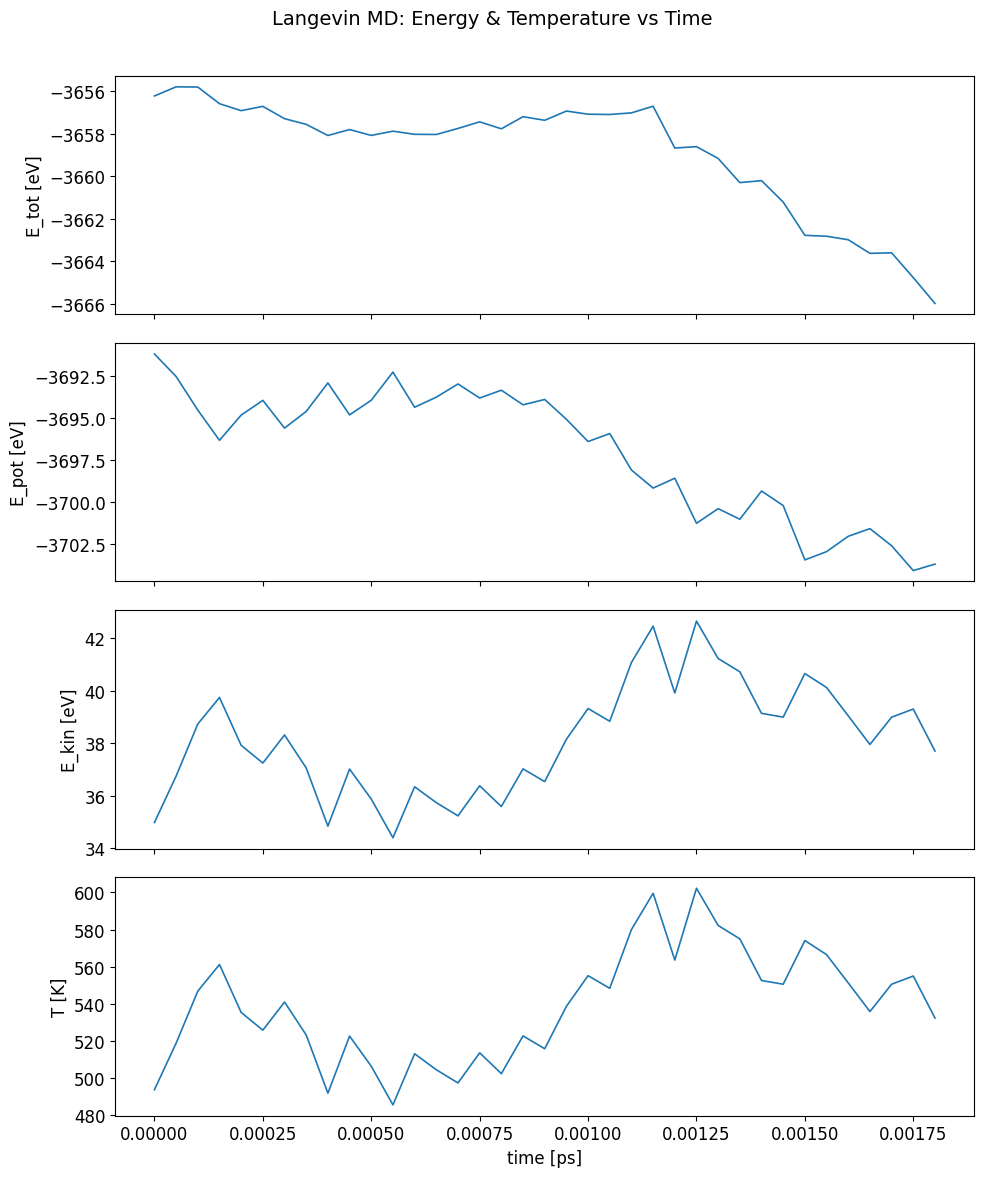

In [16]:
plot_md_log("surf_ads_md.log")

In [17]:
from ase.visualize.ngl import view_ngl

traj = Trajectory("surf_ads_md.traj")
view_ngl(traj)

In [18]:
v = traj[-1]
v.wrap()
ui = AtomEditorUI(v)
ui.display()